In [4]:
import strax 
import straxen 
import numpy as np
import matplotlib.pyplot as plt
import cutax
import pandas as pd

In [5]:
st = cutax.contexts.xenonnt_v8()

/home/luissanchez25/cutax/cutax/contexts.py:40: UserWarning: xenonnt_v8 is deprecated please use xenonnt_offline
  warnings.warn(f'xenonnt_v8 is deprecated please use xenonnt_offline')


In [6]:
data_indecies = np.load('./saved_data/kr_clean_data_index_034373.npz')['arr_0']

In [7]:
data_index = np.load('./saved_data/data_indecies_info.npz')['arr_0']

In [8]:
data_4_SOM = np.load('./saved_data/cleaned_kr_cal_data_peaks.npz')['arr_0'] #peaks of the data

In [9]:
pb_data = np.load('./saved_data/kr_clean_pb_data_v2.npz')['arr_0']

In [10]:
pb_indecies = np.load('./saved_data/pb_data_indecies.npz')

In [11]:
data_indecies_ordered = np.load('./saved_data/data_indecies_ordered.npz')['arr_0']

In [10]:
kr_peaks = st.get_array(run_id='034373', targets='peaks')

In [11]:
kr_pb = st.get_array(run_id='034373', targets='peak_basics')

In [12]:
pb_data_indexed = kr_pb[np.sort(filtered_indecies)]

NameError: name 'filtered_indecies' is not defined

In [12]:
krpb_wrep = np.load('./saved_data/clean_kr_cal_pb.npz')['arr_0']

In [13]:
_,krpb_data_indecies = np.unique(krpb_wrep, return_index=True)

In [14]:
krpb_non_repeat = krpb_wrep[np.sort(krpb_data_indecies)]

In [15]:
SE_sim_pb = np.load('./sim_data/sim_single_E_id2_peak_basics.npz')['arr_0']

In [16]:
SE_sim_peaks = np.load('./sim_data/sim_single_E_id2_peaks.npz')['arr_0']

In [17]:
SE_sim_truth = np.load('./sim_data/sim_single_E_id2_truth.npz')['arr_0']

In [18]:
Ar_sim_pb = np.load('./sim_data/sim_Ar37_id2_peak_basics.npz')['arr_0']

In [19]:
Ar_sim_peaks = np.load('./sim_data/sim_Ar37_id2_peaks.npz')['arr_0']

In [20]:
Ar_sim_truth = np.load('./sim_data/sim_Ar37_id2_truth.npz')['arr_0']

In [21]:
def assign_labels(data, ref_img, xdim, ydim, cut_out):
    '''This functions takes in the data and classifications based on an image gives the
    unique labels as well as the data set bacl with the new classification
    PS this version only takes in S1s and S2s and ignores unclassified samples, 
    another version will be made to deal with the unclassified samples
    
    data: can be either peaks or peak_basics
    ref_img: will be the image extracted from the SOM classification of each data point
    xdim: width of the image cube
    ydim: height of the image cube
    cut_out: removes the n last digits of the image vector if necesarry'''
    from PIL import Image
    data_new = data
    img = Image.open(ref_img)
    imgGray = img.convert('L')
    #imgGray2.save('/home/luissanchez25/im_kr83_real__30x30_2lbl.0.rmpmap.png')
    img_color = np.array(img) #still in the x,y,3 format
    img_color_2d = img_color.reshape((xdim*ydim,3))
    label = -1 * np.ones(img_color.shape[:-1])
    colorp = np.unique(img_color_2d, axis = 0)
    for i, color in enumerate(colorp):  # argwhere
        label[np.all((img_color == color), axis = 2)] = i #assignes each color a number
    label_vec = label.reshape((xdim*ydim))
    if cut_out != 0:
        label_vec_nonzero = label_vec[:-cut_out]
    elif cut_out == 0:
        label_vec_nonzero = label_vec
    #s2_data = data[data['type'] == 2]
    #s1_data = data[data['type'] == 1]
    #som_class_peaks = np.concatenate((s2_data,s1_data)) #note had to reverse s2,s1 to s1,s2
    data_new['type'] = label_vec_nonzero
    
    return colorp, data_new

In [22]:
def dump_matched_peaks(truth, peaks, peak_basics):#, int_type):
    """
    Dump matched peaks in a human readable format
    param truth: truth array to be matched
    param peaks: peaks array to be matched
    return data: np.array with the matched peaks and true info
    """
    #  This is for single electrons
    #if int_type == 1:
    #    truth = truth[truth['n_electron'] == 1]

    #  for now focus on S2
    s2_truth = truth
    s2_peaks = peaks
    s2_peak_basics = peak_basics

    #  This is first attemp to match peaks and true info
    mask = np.zeros(len(s2_peak_basics), dtype=np.bool)
    for i, t in enumerate(s2_truth):
        mask += ((s2_peak_basics['time'] < t['t_mean_photon']) &
                 (s2_peak_basics['endtime'] > t['t_mean_photon']))

    s2_matched = s2_peaks[mask]
    s2_peak_basics = s2_peak_basics[mask]

    #   Do not ask me why... sometimes life is hard...
    if len(s2_matched['time']) != len(s2_truth['time']):
        s2_matched, s2_peak_basics, s2_truth = match_events(s2_matched, s2_peak_basics, s2_truth)

    return s2_matched, s2_peak_basics, s2_truth

In [23]:
def match_events(s2_matched, s2_peak_basics, s2_truth):
    """
    Match s2 peaks with s2 true info
    param s2_matched: s2 peak array
    param s2_peak_basics: s2 peak_basic array
    param s2_truth: s2 truth array
    param return: s2_ms2_matched, s2_peak_basics, s2_truth matched arrays
    """
    matched = []
    matched_t = []
    '''
    for i, p in enumerate(s2_peak_basics):
        for j, t in enumerate(s2_truth):
            if abs(p['center_time']-t['t_mean_photon']) < 200:  # 200 ns window
                matched.append(i)
                matched_t.append(j)
                break
    '''
                
    for j, t in enumerate(s2_truth):     
        if np.min(abs(t['t_mean_photon'] - s2_peak_basics['center_time'])) < 200:
            pb_loc = np.where(abs(s2_peak_basics['center_time'] - t['t_mean_photon']) == np.min(abs(t['t_mean_photon'] - s2_peak_basics['center_time'])))
            matched.append(pb_loc)
            matched_t.append(j)

    s2_matched = np.take(s2_matched, matched)
    s2_peak_basics = np.take(s2_peak_basics, matched)
    s2_truth = np.take(s2_truth, matched_t)

    return s2_matched, s2_peak_basics, s2_truth

In [26]:
se_peak_mat, se_pb_mat, se_tru_mat  = dump_matched_peaks(SE_sim_truth, SE_sim_peaks, SE_sim_pb)

/tmp/ipykernel_69957/3615724949.py:18: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(len(s2_peak_basics), dtype=np.bool)


In [27]:
se_pb_mat = np.reshape(se_pb_mat, [len(se_pb_mat)])

In [28]:
color_se, se_som_cls = assign_labels(se_pb_mat, './SOM_results/im_sim_SE.0.rmpmap.png', 102, 112, 2)

In [29]:
color_se[6] = [0, 0, 0]

In [30]:
color_se

array([[  0,   0, 255],
       [  0, 128,   0],
       [  0, 255,   0],
       [ 47, 255, 254],
       [127, 133, 182],
       [255,   0,   0],
       [  0,   0,   0]], dtype=uint8)

IndexError: index 7 is out of bounds for axis 0 with size 7

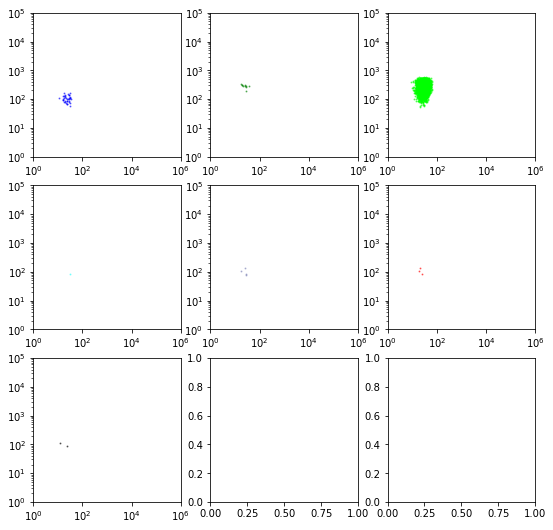

In [40]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(9, 9))

num = 0
for i in np.arange(3):
    for j in np.arange(3):
        ax[i,j].scatter(se_som_cls['area'][se_som_cls['type'] == num], 
                        se_som_cls['rise_time'][se_som_cls['type'] == num], 
                        s=1, color = color_se[num]/255, alpha = 0.5)
        ax[i,j].set_xscale('log')
        ax[i,j].set_yscale('log')
        ax[i,j].set_xlim(1,1000000)
        ax[i,j].set_ylim(1,100000)
        num = num + 1

In [31]:
def change_type(data, cls_array):
    #makes sure you give a label to each data set
    data_s1s2 = data.copy()
    assert len(cls_array) == len(np.unique(data['type']))
    for i in np.arange(len(np.unique(data_s1s2['type']))):
        data_s1s2['type'] = np.where(data_s1s2['type'] != i, data_s1s2['type'], cls_array[i])
        
    return data_s1s2

In [32]:
se_s1s2 = change_type(se_som_cls, np.array([1,2,2,1,1,1,1]))

In [33]:
len(se_s1s2[se_s1s2['type'] == 2])/ len(se_s1s2)

0.9991244965855367

In [34]:
len(se_pb_mat[se_pb_mat['type'] == 2]) / len(se_pb_mat)

0.9950971808790054

In [35]:
se_pb_mat.dtype

dtype([(('Start time of the peak (ns since unix epoch)', 'time'), '<i8'), (('End time of the peak (ns since unix epoch)', 'endtime'), '<i8'), (('Weighted center time of the peak (ns since unix epoch)', 'center_time'), '<i8'), (('Peak integral in PE', 'area'), '<f4'), (('Number of PMTs contributing to the peak', 'n_hits'), '<i4'), (('Number of hits contributing at least one sample to the peak', 'n_channels'), '<i2'), (('PMT number which contributes the most PE', 'max_pmt'), '<i2'), (('Area of signal in the largest-contributing PMT (PE)', 'max_pmt_area'), '<f4'), (('Total number of saturated channels', 'n_saturated_channels'), '<i2'), (('Width (in ns) of the central 50% area of the peak', 'range_50p_area'), '<f4'), (('Width (in ns) of the central 90% area of the peak', 'range_90p_area'), '<f4'), (('Fraction of area seen by the top array (NaN for peaks with non-positive area)', 'area_fraction_top'), '<f4'), (('Length of the peak waveform in samples', 'length'), '<i4'), (('Time resolution 

## Now lets look at the obviously bad data

In [36]:
ar_peak_mat, ar_pb_mat, ar_tru_mat  = dump_matched_peaks(Ar_sim_truth, Ar_sim_peaks, Ar_sim_pb)

/tmp/ipykernel_69957/3615724949.py:18: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(len(s2_peak_basics), dtype=np.bool)


In [37]:
ar_pb_mat = np.reshape(ar_pb_mat, [len(ar_pb_mat)])

In [38]:
len(ar_pb_mat[ar_tru_mat['type'] == 1])

22306

In [39]:
color_ar, ar_som_cls = assign_labels(ar_pb_mat[ar_tru_mat['type'] == 1], './SOM_results/im_sim_ar37_high_rt.0.rmpmap.png', 143, 156, 2)

In [40]:
color_ar

array([[  0,   0, 255],
       [  0, 164, 255],
       [  0, 255,   0],
       [ 45, 132,   0],
       [127, 133, 182],
       [179, 175, 255],
       [200, 164,   0],
       [200, 200,   0],
       [210, 180, 210],
       [255,   0,   0],
       [255,   0, 255],
       [255, 164,   0],
       [255, 164, 179],
       [255, 164, 255],
       [255, 254,   0],
       [255, 255,   0]], dtype=uint8)

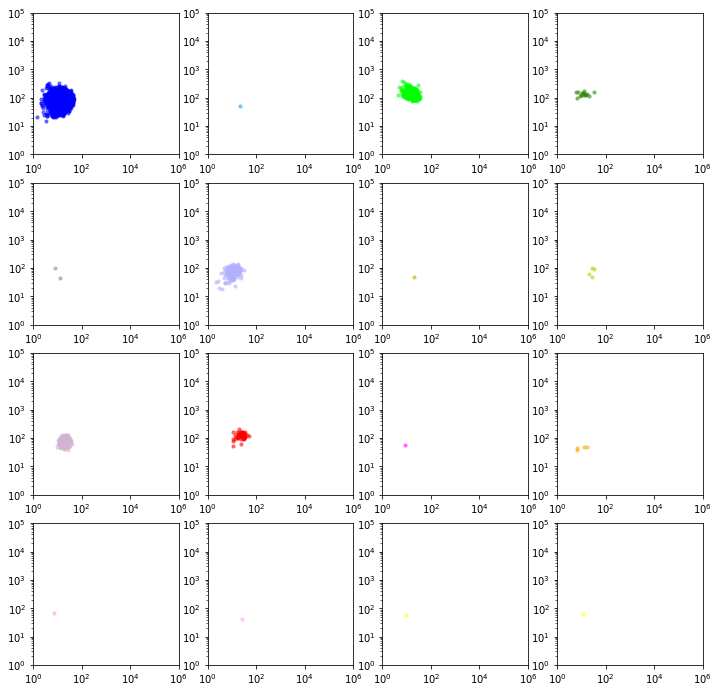

In [79]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))

num = 0
for i in np.arange(4):
    for j in np.arange(4):
        ax[i,j].scatter(ar_som_cls['area'][ar_som_cls['type'] == num], 
                        ar_som_cls['rise_time'][ar_som_cls['type'] == num], 
                        s=10, color = color_ar[num]/255, alpha = 0.5)
        ax[i,j].set_xscale('log')
        ax[i,j].set_yscale('log')
        ax[i,j].set_xlim(1,1000000)
        ax[i,j].set_ylim(1,100000)
        num = num + 1

In [41]:
ar_s1s2 = change_type(ar_som_cls, np.array([1,1,2,2,1,1,2,1,1,1,2,2,2,2,2,2]))

In [42]:
def SOM_labels_confusion_matrix_mod(image_loc, data_partitions, zeros_in_data, S1_labels):
    '''*** NOTE THIS FUNCTION WILL ONLY WORK FOR THIS DATA SET ***'''
    partitions = undo_cumsum(data_partitions) #indecies but we need length of segments
    partitions = partitions.astype(int)
    data_labels = np.array(np.concatenate((np.tile(3,partitions[0]),
                                           np.tile(4,partitions[1]),
                                           np.tile(1,partitions[2]),
                                           np.tile(2,partitions[3]))), 
                                           dtype = [('type', '<i8')])
    #make data a binary classification
    data_labels_binary = data_labels
    #sets all labels that are not 1 equal to 2 (works for this )
    data_labels_binary['type'] = np.where(data_labels_binary['type'] != 1, 
                                          data_labels_binary['type'], 
                                          0)
    data_labels_binary['type'] = np.where(data_labels_binary['type'] <= 1,
                                          data_labels_binary['type'], 
                                          2)
    data_labels_binary['type'] = np.where(data_labels_binary['type'] != 0,
                                          data_labels_binary['type'], 
                                          1)
    

    #
    [SOM_data_unique_labels , SOM_data_labeled] = assign_labels(data_labels_binary,
                                                                image_loc, 
                                                                400, 1235, 
                                                                zeros_in_data)
    
    #takes SOM labels into a binary classification (ASSUMSES 2ND LABEL IS BLUE)
    #Should probably figure out a better way to do that but lets try it
    SOM_data_labeled_binary = SOM_data_labeled
    for label in S1_labels:
        #turns certain labels into S1s
        SOM_data_labeled_binary['type'] = np.where(SOM_data_labeled_binary['type'] != label, 
                                                   SOM_data_labeled_binary['type'], -1)
    SOM_data_labeled_binary['type'] = np.where(SOM_data_labeled_binary['type'] == -1, 
                                               SOM_data_labeled_binary['type'], 2)
    SOM_data_labeled_binary['type'] = np.where(SOM_data_labeled_binary['type'] != -1, 
                                               SOM_data_labeled_binary['type'], 1)
    
    
    confusion_matrix_binomial_error(data_labels_binary,SOM_data_labeled_binary)
    
    return data_labels_binary, SOM_data_labeled_binary

In [43]:
def undo_cumsum(array):
    output = np.zeros(len(array))
    output[0] = array[0]
    for num in np.arange(len(array)-1):
        output[num+1] = array[num+1]-(array[num])
        
    return output

In [44]:
from sklearn import metrics

In [45]:
np.unique(ar_s1s2['type'])

array([1, 2], dtype=int8)

In [46]:
np.unique(ar_tru_mat[ar_tru_mat['type'] == 1]['type'])

array([1], dtype=int8)

In [47]:
len(ar_s1s2[ar_s1s2['type'] == 1]) / len(ar_tru_mat[ar_tru_mat['type'] == 1])

0.9689769568725903

In [48]:
ar_s1 = ar_peak_mat[ar_tru_mat['type'] == 1]

In [49]:
len(ar_s1[ar_s1['type'] == 1]) / len(ar_tru_mat[ar_tru_mat['type'] == 1])

0.5605666636779342

## Now we look at the good ar37 data

In [50]:
sim_ar_37_data = np.load('./sim_data/Ar37_sim_s1.npy')

In [51]:
sim_ar_37_truth = sim_ar_37_data

In [52]:
sim_ar_37_truth['type'] = 1

In [53]:
color_ar_sim, ar_sim_som_cls = assign_labels(sim_ar_37_data, './SOM_results/im_ar37_s1_goodrt.0.rmpmap.png', 100, 100, 8)

In [54]:
len(color_ar_sim)

13

In [55]:
color_ar_sim

array([[  0,   0, 255],
       [ 45, 132,   0],
       [ 47, 200, 254],
       [179, 175, 255],
       [200, 200,   0],
       [210, 180, 210],
       [255,   0,   0],
       [255,  47, 164],
       [255,  47, 254],
       [255, 200, 164],
       [255, 200, 254],
       [255, 255, 164],
       [255, 255, 254]], dtype=uint8)

In [56]:
len(ar_sim_som_cls[ar_sim_som_cls['type'] == 2])

0

IndexError: index 13 is out of bounds for axis 0 with size 13

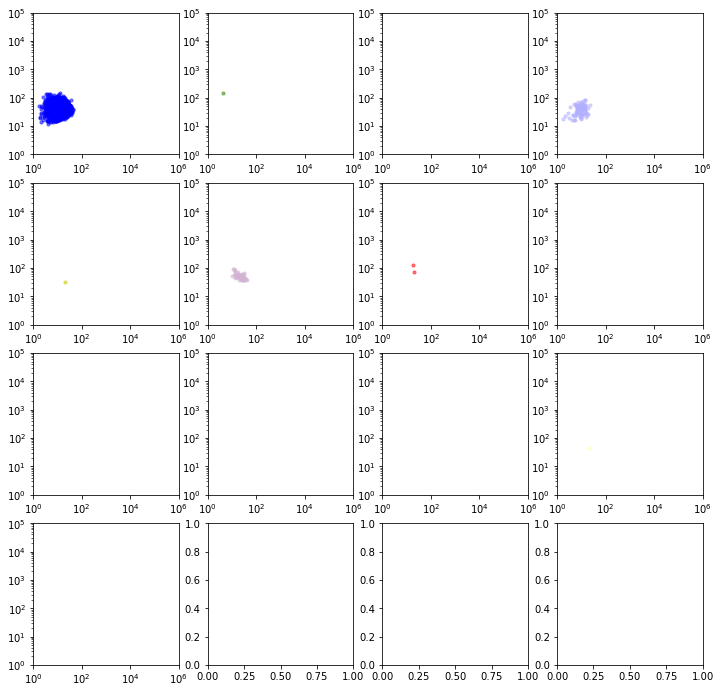

In [99]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))

num = 0
for i in np.arange(4):
    for j in np.arange(4):
        ax[i,j].scatter(ar_sim_som_cls['area'][ar_sim_som_cls['type'] == num], 
                        ar_sim_som_cls['rise_time'][ar_sim_som_cls['type'] == num], 
                        s=10, color = color_ar_sim[num]/255, alpha = 0.5)
        ax[i,j].set_xscale('log')
        ax[i,j].set_yscale('log')
        ax[i,j].set_xlim(1,1000000)
        ax[i,j].set_ylim(1,100000)
        num = num + 1

In [57]:
ar_s1s2_goodrt = change_type(ar_sim_som_cls, np.array([1,2,1,1,1,1,2]))

In [58]:
len(ar_s1s2_goodrt[ar_s1s2_goodrt['type'] == 1]) / len(ar_s1s2_goodrt) #SOM

0.9996997598078463

In [59]:
len(sim_ar_37_data[sim_ar_37_data['type'] == 1]) / len(sim_ar_37_data) #SOM

0.00010008006405124099

In [60]:
sim_ar_37_data['type']

array([ 0,  0,  0, ...,  0,  0, 11], dtype=int8)

## Now time to make the money plots!

In [61]:
from matplotlib import cm

In [62]:
from matplotlib.lines import Line2D

In [63]:
def compute_s1_boundary(parm, area):
    boundary_line = parm[0]*np.exp(-area/parm[1]) + parm[2]
    
    return boundary_line

In [64]:
parm2 = np.array([100, 80, 12])
area_linspace =  np.linspace(1, 100, 200)

In [65]:
parm2 = np.array([50, 12, 80])

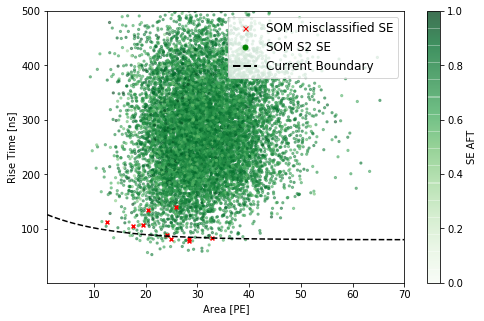

In [70]:
fig = plt.figure(figsize=(8,5))

vmin = 0
vmax = 1
m1 = plt.scatter(se_s1s2['area'][se_s1s2['type'] == 2], 
            se_s1s2['rise_time'][se_s1s2['type'] == 2], 
            s=5, alpha = 0.5, c= se_s1s2['area_fraction_top'][se_s1s2['type'] == 2],
            vmin=vmin, vmax=vmax, label = 'SOM S2 SE', 
            cmap=cm.get_cmap('Greens'))
plt.colorbar(m1, label = 'SE AFT')
plt.scatter(se_s1s2['area'][se_s1s2['type'] == 1], 
            se_s1s2['rise_time'][se_s1s2['type'] == 1], 
            s=15, alpha = 1, marker = 'x', color = 'red',
            label = 'SOM misclassified SE')
#plt.colorbar(m2, label = 'S1 AFT')
plt.plot(area_linspace, compute_s1_boundary(parm2, area_linspace),
         '--' ,color = 'black', label = 'Straxen Boundary')
#plt.scatter(kr_pb_array['area'][kr_pb_array['type'] == 1], kr_pb_array['rise_time'][kr_pb_array['type'] == 1], s=0.1, color = 'blue')
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Area [PE]')
plt.ylabel('Rise Time [ns]')
legend_elements = [Line2D([0], [0], marker='x', color='red', label='SOM misclassified SE',markerfacecolor='red',linewidth=0, markersize=5),
                   Line2D([0], [0], marker='o', color='green', label='SOM S2 SE',markerfacecolor='green',linewidth=0, markersize=5),
                   Line2D([0], [0], linestyle='--', color='black', label='Current Boundary',markerfacecolor='black',linewidth=2, markersize=5)]

plt.legend(handles=legend_elements, loc=1,prop={'size':12})
#plt.colorbar()
#plt.legend(markerscale=4)
plt.xlim(1,70)
plt.ylim(1,500)
plt.savefig('./sim_figures/sim_se_SOM_cls_rt_v_area_APS.png', dpi = 1200)

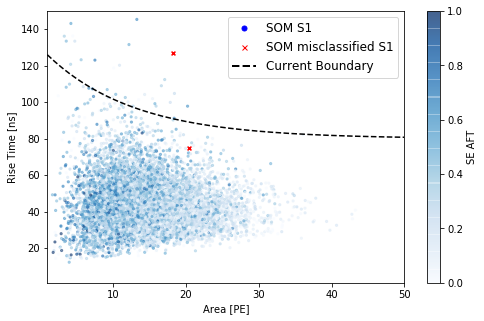

In [78]:
fig = plt.figure(figsize=(8,5))

vmin = 0
vmax = 1
m1 = plt.scatter(ar_s1s2_goodrt['area'][ar_s1s2_goodrt['type'] == 1], 
            ar_s1s2_goodrt['rise_time'][ar_s1s2_goodrt['type'] == 1], 
            s=5, alpha = 0.5, c= ar_s1s2_goodrt['area_fraction_top'][ar_s1s2_goodrt['type'] == 1],
            vmin=vmin, vmax=vmax, label = 'SOM S2 SE', 
            cmap=cm.get_cmap('Blues'))
plt.colorbar(m1, label = 'SE AFT')
plt.scatter(ar_s1s2_goodrt['area'][ar_s1s2_goodrt['type'] == 2], 
            ar_s1s2_goodrt['rise_time'][ar_s1s2_goodrt['type'] == 2], 
            s=15, alpha = 1, marker = 'x', color = 'red',
            label = 'SOM misclassified SE')
#plt.colorbar(m2, label = 'S1 AFT')
plt.plot(area_linspace, compute_s1_boundary(parm2, area_linspace),
         '--' ,color = 'black', label = 'Straxen Boundary')
#plt.scatter(kr_pb_array['area'][kr_pb_array['type'] == 1], kr_pb_array['rise_time'][kr_pb_array['type'] == 1], s=0.1, color = 'blue')
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Area [PE]')
plt.ylabel('Rise Time [ns]')
legend_elements = [Line2D([0], [0], marker='o', color='blue', label='SOM S1',markerfacecolor='blue',linewidth=0, markersize=5),
                   Line2D([0], [0], marker='x', color='red', label='SOM misclassified S1',markerfacecolor='red',linewidth=0, markersize=5),
                   Line2D([0], [0], linestyle='--', color='black', label='Current Boundary',markerfacecolor='black',linewidth=2, markersize=5)]

plt.legend(handles=legend_elements, loc=1,prop={'size':12})
#plt.colorbar()
#plt.legend(markerscale=4)
plt.xlim(1,50)
plt.ylim(1,150)
plt.savefig('./sim_figures/sim_ar_SOM_cls_rt_v_area_APS.png', dpi = 1200)

In [74]:
def upper_rise_time_aft_boundary(aft, slope, offset, aft_boundary, flat_threshold):
        """
        Function which computes the upper rise time boundary as a function
        of area fraction top.
        """
        res = 10**(slope * aft + offset)
        res[aft >= aft_boundary] = flat_threshold
        return res

In [75]:
aft_bound_parm = np.array([-1, 2.6, 0.6, 100])

In [76]:
aft_line = np.linspace(0,1,100)

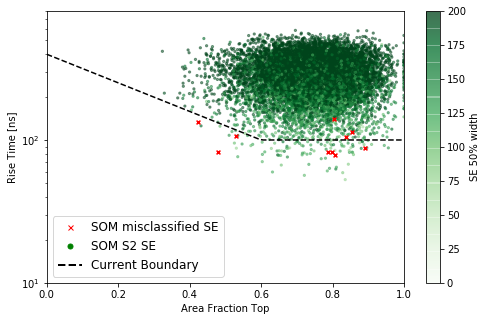

In [77]:
fig = plt.figure(figsize=(8,5))

vmin = 0
vmax = 200
m1 = plt.scatter(se_s1s2['area_fraction_top'][se_s1s2['type'] == 2], 
            se_s1s2['rise_time'][se_s1s2['type'] == 2], 
            s=5, alpha = 0.5, c= se_s1s2['range_50p_area'][se_s1s2['type'] == 2],
            vmin=vmin, vmax=vmax, label = 'SOM S2 SE', 
            cmap=cm.get_cmap('Greens'))
plt.colorbar(m1, label = 'SE 50% width')
plt.scatter(se_s1s2['area_fraction_top'][se_s1s2['type'] == 1], 
            se_s1s2['rise_time'][se_s1s2['type'] == 1], 
            s=15, alpha = 1, marker = 'x', color = 'red',
            label = 'SOM misclassified SE')
#plt.colorbar(m2, label = 'S1 AFT')
plt.plot(aft_line, upper_rise_time_aft_boundary(aft_line, aft_bound_parm[0],
                                               aft_bound_parm[1],aft_bound_parm[2],
                                               aft_bound_parm[3]),'--' ,color = 'black', label = "Straxen AFT boundary")

plt.xlabel('Area Fraction Top')
plt.ylabel('Rise Time [ns]')
legend_elements = [Line2D([0], [0], marker='x', color='red', label='SOM misclassified SE',markerfacecolor='red',linewidth=0, markersize=5),
                   Line2D([0], [0], marker='o', color='green', label='SOM S2 SE',markerfacecolor='green',linewidth=0, markersize=5),
                   Line2D([0], [0], linestyle='--', color='black', label='Current Boundary',markerfacecolor='black',linewidth=2, markersize=5)]

plt.legend(handles=legend_elements, loc=0,prop={'size':12})
#plt.colorbar()
#plt.legend(markerscale=4)
plt.yscale('log')
plt.xlim(0,1)
plt.ylim(10,800)
plt.savefig('./sim_figures/sim_se_SOM_cls_rt_v_aft_APS.png', dpi = 1200)

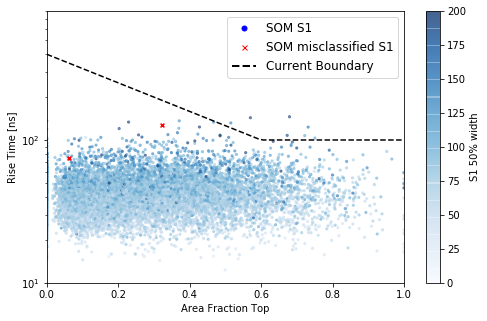

In [79]:
fig = plt.figure(figsize=(8,5))

vmin = 0
vmax = 200
m1 = plt.scatter(ar_s1s2_goodrt['area_fraction_top'][ar_s1s2_goodrt['type'] == 1], 
            ar_s1s2_goodrt['rise_time'][ar_s1s2_goodrt['type'] == 1], 
            s=5, alpha = 0.5, c= ar_s1s2_goodrt['range_50p_area'][ar_s1s2_goodrt['type'] == 1],
            vmin=vmin, vmax=vmax, label = 'SOM S2 SE', 
            cmap=cm.get_cmap('Blues'))
plt.colorbar(m1, label = 'S1 50% width')
plt.scatter(ar_s1s2_goodrt['area_fraction_top'][ar_s1s2_goodrt['type'] == 2], 
            ar_s1s2_goodrt['rise_time'][ar_s1s2_goodrt['type'] == 2], 
            s=15, alpha = 1, marker = 'x', color = 'red',
            label = 'SOM misclassified SE')
#plt.colorbar(m2, label = 'S1 AFT')
plt.plot(aft_line, upper_rise_time_aft_boundary(aft_line, aft_bound_parm[0],
                                               aft_bound_parm[1],aft_bound_parm[2],
                                               aft_bound_parm[3]),'--' ,color = 'black', label = "Straxen AFT boundary")

plt.xlabel('Area Fraction Top')
plt.ylabel('Rise Time [ns]')
legend_elements = [Line2D([0], [0], marker='o', color='blue', label='SOM S1',markerfacecolor='blue',linewidth=0, markersize=5),
                   Line2D([0], [0], marker='x', color='red', label='SOM misclassified S1',markerfacecolor='red',linewidth=0, markersize=5),
                   Line2D([0], [0], linestyle='--', color='black', label='Current Boundary',markerfacecolor='black',linewidth=2, markersize=5)]

plt.legend(handles=legend_elements, loc=1,prop={'size':12})
#plt.colorbar()
#plt.legend(markerscale=4)
plt.yscale('log')
plt.xlim(0,1)
plt.ylim(10,800)
plt.savefig('./sim_figures/sim_ar_SOM_cls_rt_v_aft_APS.png', dpi = 1200)

## Next up we need the plots with the wierd simulates Ar37 S1

First lets show what make this data wierd, plot risetime vs area and plot some of the good waveforms vs the bad waveforms

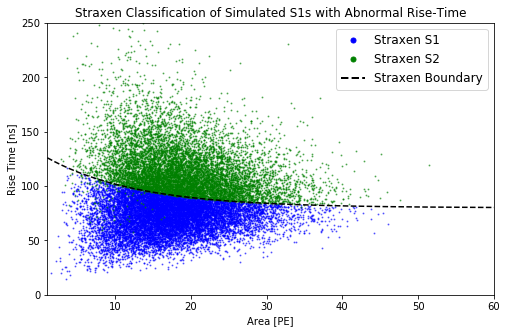

In [229]:
fig = plt.figure(figsize=(8,5))

vmin = 0
vmax = 1
plt.scatter(ar_pb_mat['area'][ar_pb_mat['type'] == 1], 
            ar_pb_mat['rise_time'][ar_pb_mat['type'] == 1], 
            s=1, alpha = 0.5, 
            vmin=vmin, vmax=vmax, label = 'SOM S2 SE', 
            color = 'blue')
plt.scatter(ar_pb_mat['area'][ar_pb_mat['type'] == 2], 
            ar_pb_mat['rise_time'][ar_pb_mat['type'] == 2], 
            s=1, alpha = 0.5, color = 'green',
            label = 'SOM misclassified SE')
#plt.colorbar(m2, label = 'S1 AFT')
plt.plot(area_linspace, compute_s1_boundary(parm2, area_linspace),
         '--' ,color = 'black', label = 'Straxen Boundary')
#plt.scatter(kr_pb_array['area'][kr_pb_array['type'] == 1], kr_pb_array['rise_time'][kr_pb_array['type'] == 1], s=0.1, color = 'blue')
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Area [PE]')
plt.ylabel('Rise Time [ns]')
legend_elements = [Line2D([0], [0], marker='o', color='blue', label='Straxen S1',markerfacecolor='blue',linewidth=0, markersize=5),
                   Line2D([0], [0], marker='o', color='green', label='Straxen S2',markerfacecolor='green',linewidth=0, markersize=5),
                   Line2D([0], [0], linestyle='--', color='black', label='Straxen Boundary',markerfacecolor='black',linewidth=2, markersize=5)]

plt.legend(handles=legend_elements, loc=1,prop={'size':12})
#plt.colorbar()
#plt.legend(markerscale=4)
plt.title('Straxen Classification of Simulated S1s with Abnormal Rise-Time')
plt.xlim(1,60)
plt.ylim(0,250)
plt.savefig('./sim_figures/sim_ar_highrt_straxen_cls_rt_v_area.png', dpi = 1200)

In [189]:
ar_peak_mat = np.reshape(ar_peak_mat, [len(ar_peak_mat)])

In [187]:
np.shape(ar_peak_mat)

(42112, 1, 1)

In [197]:
ar37_bad_s1 = ar_peak_mat[ar_tru_mat['type'] == 1]

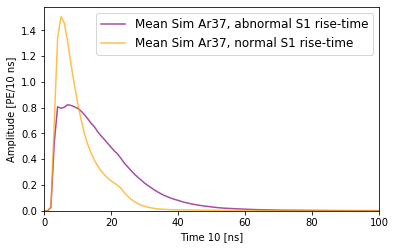

In [233]:
fig = plt.figure(figsize=(6,3.75))
plt.plot(np.mean(ar37_bad_s1['data'], axis = 0), 
         alpha = 0.7, color = 'purple', label = "Mean Sim Ar37, abnormal S1 rise-time")
plt.plot(np.mean(sim_ar_37_data['data'], axis = 0), 
         alpha = 0.7, color = 'orange', label = "Mean Sim Ar37, normal S1 rise-time")
plt.xlim(0,100)
plt.ylim(0)
plt.xlabel('Time 10 [ns]')
plt.ylabel('Amplitude [PE/10 ns]')
plt.legend(fontsize = 12)
plt.savefig('./sim_figures/ar_peak_normal_rt_vs_high_rt.png', dpi = 1200)

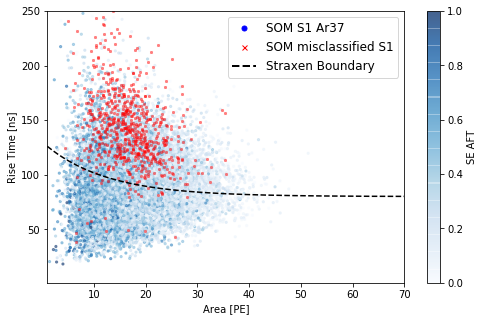

In [231]:
fig = plt.figure(figsize=(8,5))

vmin = 0
vmax = 1
m1 = plt.scatter(ar_s1s2['area'][ar_s1s2['type'] == 1], 
            ar_s1s2['rise_time'][ar_s1s2['type'] == 1], 
            s=5, alpha = 0.5, c= ar_s1s2['area_fraction_top'][ar_s1s2['type'] == 1],
            vmin=vmin, vmax=vmax, label = 'SOM S2 SE', 
            cmap=cm.get_cmap('Blues'))
plt.colorbar(m1, label = 'SE AFT')
plt.scatter(ar_s1s2['area'][ar_s1s2['type'] == 2], 
            ar_s1s2['rise_time'][ar_s1s2['type'] == 2], 
            s=5, alpha = 0.5, marker = 'x', color = 'red',
            label = 'SOM misclassified SE')
#plt.colorbar(m2, label = 'S1 AFT')
plt.plot(area_linspace, compute_s1_boundary(parm2, area_linspace),
         '--' ,color = 'black', label = 'Straxen Boundary')
#plt.scatter(kr_pb_array['area'][kr_pb_array['type'] == 1], kr_pb_array['rise_time'][kr_pb_array['type'] == 1], s=0.1, color = 'blue')
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Area [PE]')
plt.ylabel('Rise Time [ns]')
legend_elements = [Line2D([0], [0], marker='o', color='blue', label='SOM S1 Ar37',markerfacecolor='blue',linewidth=0, markersize=5),
                   Line2D([0], [0], marker='x', color='red', label='SOM misclassified S1',markerfacecolor='red',linewidth=0, markersize=5),
                   Line2D([0], [0], linestyle='--', color='black', label='Straxen Boundary',markerfacecolor='black',linewidth=2, markersize=5)]

plt.legend(handles=legend_elements, loc=1,prop={'size':12})
#plt.colorbar()
#plt.legend(markerscale=4)
plt.xlim(1,70)
plt.ylim(1,250)
plt.savefig('./sim_figures/sim_ar_high_rt_SOM_cls_rt_v_area.png', dpi = 1200)

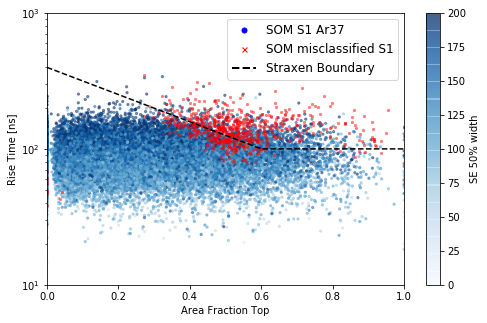

In [232]:
fig = plt.figure(figsize=(8,5))

vmin = 0
vmax = 200
m1 = plt.scatter(ar_s1s2['area_fraction_top'][ar_s1s2['type'] == 1], 
            ar_s1s2['rise_time'][ar_s1s2['type'] == 1], 
            s=5, alpha = 0.5, c= ar_s1s2['range_50p_area'][ar_s1s2['type'] == 1],
            vmin=vmin, vmax=vmax, label = 'SOM S2 SE', 
            cmap=cm.get_cmap('Blues'))
plt.colorbar(m1, label = 'SE 50% width')
plt.scatter(ar_s1s2['area_fraction_top'][ar_s1s2['type'] == 2], 
            ar_s1s2['rise_time'][ar_s1s2['type'] == 2], 
            s=5, alpha = 0.5, marker = 'x', color = 'red',
            label = 'SOM misclassified SE')
#plt.colorbar(m2, label = 'S1 AFT')
plt.plot(aft_line, upper_rise_time_aft_boundary(aft_line, aft_bound_parm[0],
                                               aft_bound_parm[1],aft_bound_parm[2],
                                               aft_bound_parm[3]),'--' ,color = 'black', label = "Straxen AFT boundary")

plt.xlabel('Area Fraction Top')
plt.ylabel('Rise Time [ns]')
legend_elements = [Line2D([0], [0], marker='o', color='blue', label='SOM S1 Ar37',markerfacecolor='blue',linewidth=0, markersize=5),
                   Line2D([0], [0], marker='x', color='red', label='SOM misclassified S1',markerfacecolor='red',linewidth=0, markersize=5),
                   Line2D([0], [0], linestyle='--', color='black', label='Straxen Boundary',markerfacecolor='black',linewidth=2, markersize=5)]

plt.legend(handles=legend_elements, loc=0,prop={'size':12})
#plt.colorbar()
#plt.legend(markerscale=4)
plt.yscale('log')
plt.xlim(0,1)
plt.ylim(10,1000)
plt.savefig('./sim_figures/sim_ar_high_rt_SOM_cls_rt_v_aft.png', dpi = 1200)

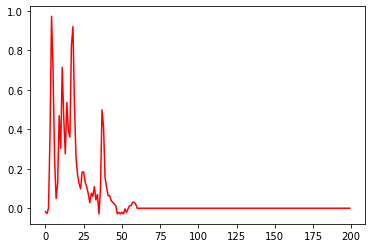

In [194]:
plt.plot((ar_peak_mat['data'][0]), color = 'red')

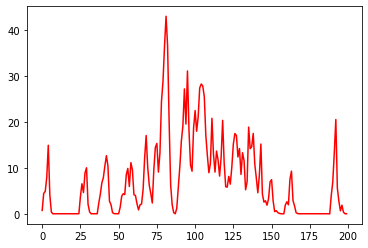

In [195]:
plt.plot((ar_peak_mat['data'][1]), color = 'red')

In [166]:
ar_peak_mat.dtype

dtype([(('Start time since unix epoch [ns]', 'time'), '<i8'), (('Length of the interval in samples', 'length'), '<i4'), (('Width of one sample [ns]', 'dt'), '<i4'), (('Channel/PMT number', 'channel'), '<i2'), (('Classification of the peak(let)', 'type'), 'i1'), (('Integral across channels [PE]', 'area'), '<f4'), (('Integral per channel [PE]', 'area_per_channel'), '<f4', (494,)), (('Number of hits contributing at least one sample to the peak ', 'n_hits'), '<i4'), (('Waveform data in PE/sample (not PE/ns!)', 'data'), '<f4', (200,)), (('Peak widths in range of central area fraction [ns]', 'width'), '<f4', (11,)), (('Peak widths: time between nth and 5th area decile [ns]', 'area_decile_from_midpoint'), '<f4', (11,)), (('Does the channel reach ADC saturation?', 'saturated_channel'), 'i1', (494,)), (('Total number of saturated channels', 'n_saturated_channels'), '<i2'), (('Channel within tight range of mean', 'tight_coincidence'), '<i2'), (('Largest gap between hits inside peak [ns]', 'max_g